In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Параметры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
image_size = 28
channels = 1
batch_size = 128
epochs = 10
lr = 0.0002
beta1 = 0.5

# Загрузка данных MNIST
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [106]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # Вход: z [batch, 100, 1, 1]
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # [batch, 256, 7, 7]
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # [batch, 128, 14, 14]
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # [batch, 64, 28, 28]
            
            nn.Conv2d(64, channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
            # Выход: [batch, 1, 28, 28]
        )

    def forward(self, x):
        return self.main(x)

In [107]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # Вход: [batch, 1, 28, 28]
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # [batch, 64, 14, 14]
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # [batch, 128, 7, 7]
            
            nn.Conv2d(128, 256, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # [batch, 256, 1, 1]
            
            #эквивалетно линейному слою
            nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
            # [batch, 1]
        )

    def forward(self, x):
        return self.main(x)

In [108]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [113]:
def train(lr, latent_dim, beta1):
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    criterion = nn.BCELoss()
    
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
    img_list = []
    G_losses = []
    D_losses = []
    
    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            
            real_label = torch.ones(batch_size, 1, device=device)
            fake_label = torch.zeros(batch_size, 1, device=device)
            
            optimizer_D.zero_grad()
            output_real = discriminator(real_imgs)
            loss_real = criterion(output_real, real_label)
            
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = generator(noise)
            
            output_fake = discriminator(fake_imgs.detach())
            loss_fake = criterion(output_fake, fake_label)
            
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()
            
            optimizer_G.zero_grad()
            output = discriminator(fake_imgs)
            loss_G = criterion(output, real_label)
            loss_G.backward()
            optimizer_G.step()
            
            D_losses.append(loss_D.item())
            G_losses.append(loss_G.item())
            #progress_bar.set_postfix({'D_loss': loss_D.item(), 'G_loss': loss_G.item()})
        
        if epoch % 2 == 0:
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
                grid = torchvision.utils.make_grid(fake, padding=2, normalize=True, nrow=8)
                img_list.append(grid)
            
            print(f'[Epoch {epoch+1}/{epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}')
            
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title(f"Generated Images - Epoch {epoch+1}")
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.savefig(f'gan_epoch_{epoch+1}.png')
            plt.close()
    
    if img_list:
        num_checkpoints = len(img_list)
    
        fig, axs = plt.subplots(num_checkpoints, 1, figsize=(15, 30))

    
        for i in range(num_checkpoints):
            axs[i].imshow(np.transpose(img_list[i], (1, 2, 0)))
            axs[i].set_title(f'Epoch {i*2+1}') 
            axs[i].axis('off')
    
        plt.figure(figsize=(10, 5))
        plt.plot(G_losses, label='Generator')
        plt.plot(D_losses, label='Discriminator')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No images generated during training")

Комбинация 1: lr=0.0002, beta1=0.5, latent_dim=80
[Epoch 1/10] Loss_D: 1.1363 Loss_G: 0.9004
[Epoch 3/10] Loss_D: 1.0927 Loss_G: 0.9950
[Epoch 5/10] Loss_D: 1.0144 Loss_G: 1.1771
[Epoch 7/10] Loss_D: 0.9832 Loss_G: 1.2027
[Epoch 9/10] Loss_D: 1.1242 Loss_G: 1.1614


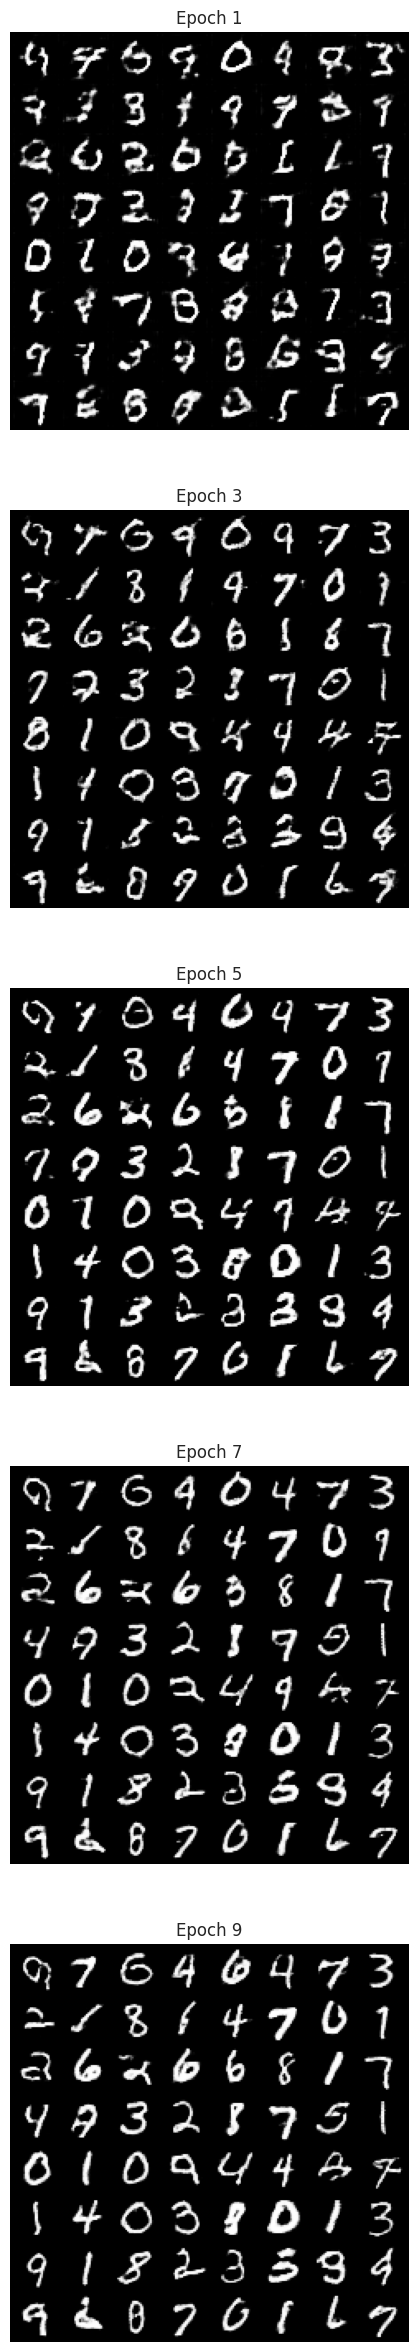

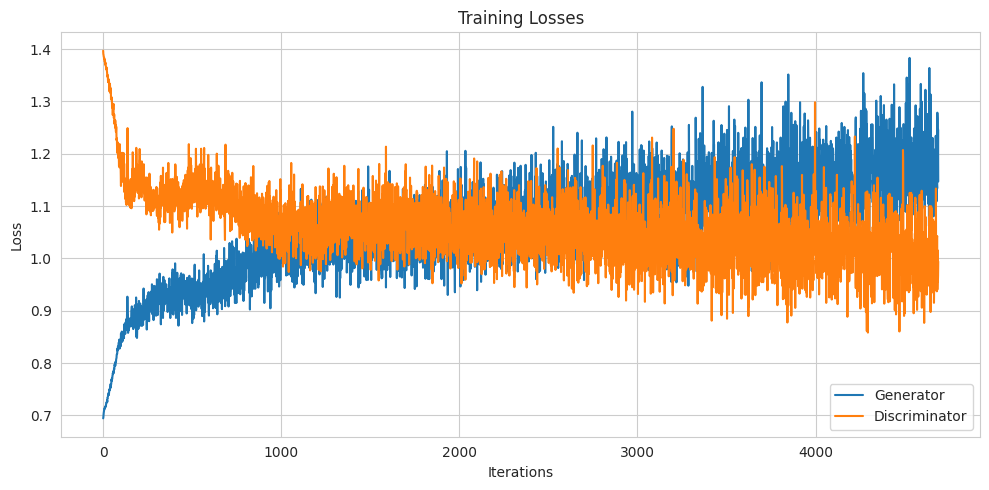

Комбинация 2: lr=0.0002, beta1=0.5, latent_dim=100
[Epoch 1/10] Loss_D: 1.1455 Loss_G: 0.9551
[Epoch 3/10] Loss_D: 1.0324 Loss_G: 1.1815
[Epoch 5/10] Loss_D: 0.9524 Loss_G: 1.1399
[Epoch 7/10] Loss_D: 1.0372 Loss_G: 1.1838
[Epoch 9/10] Loss_D: 1.0616 Loss_G: 1.2605


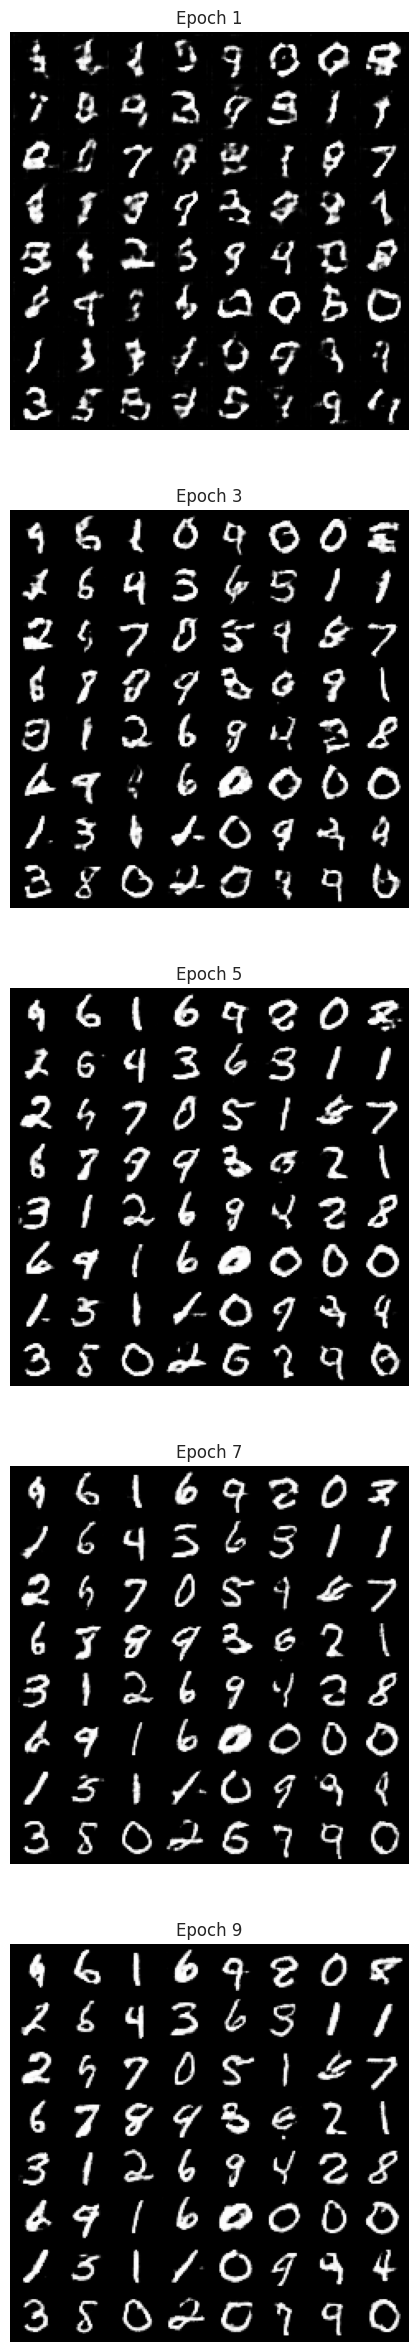

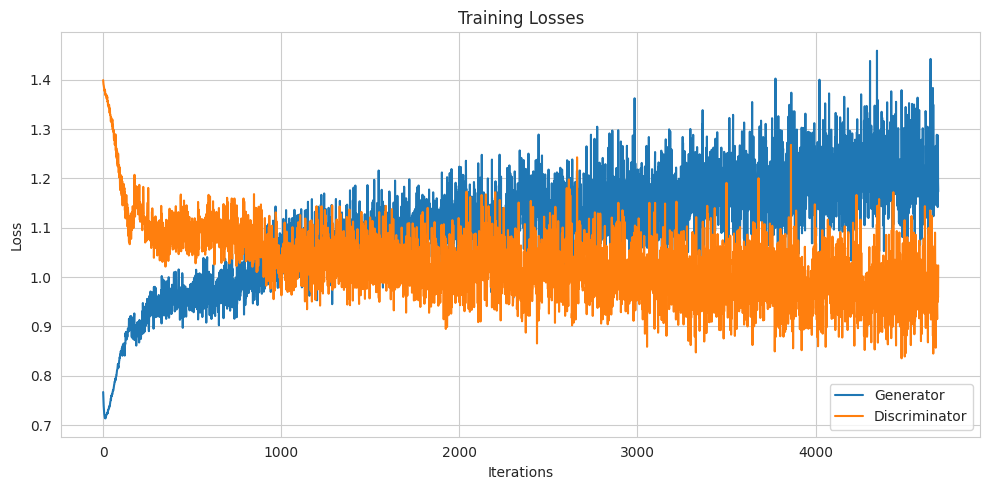

Комбинация 3: lr=0.0002, beta1=0.6, latent_dim=80
[Epoch 1/10] Loss_D: 1.1190 Loss_G: 0.9362
[Epoch 3/10] Loss_D: 1.0677 Loss_G: 1.0295
[Epoch 5/10] Loss_D: 1.1036 Loss_G: 1.0881
[Epoch 7/10] Loss_D: 1.0054 Loss_G: 1.1738
[Epoch 9/10] Loss_D: 1.0703 Loss_G: 1.1492


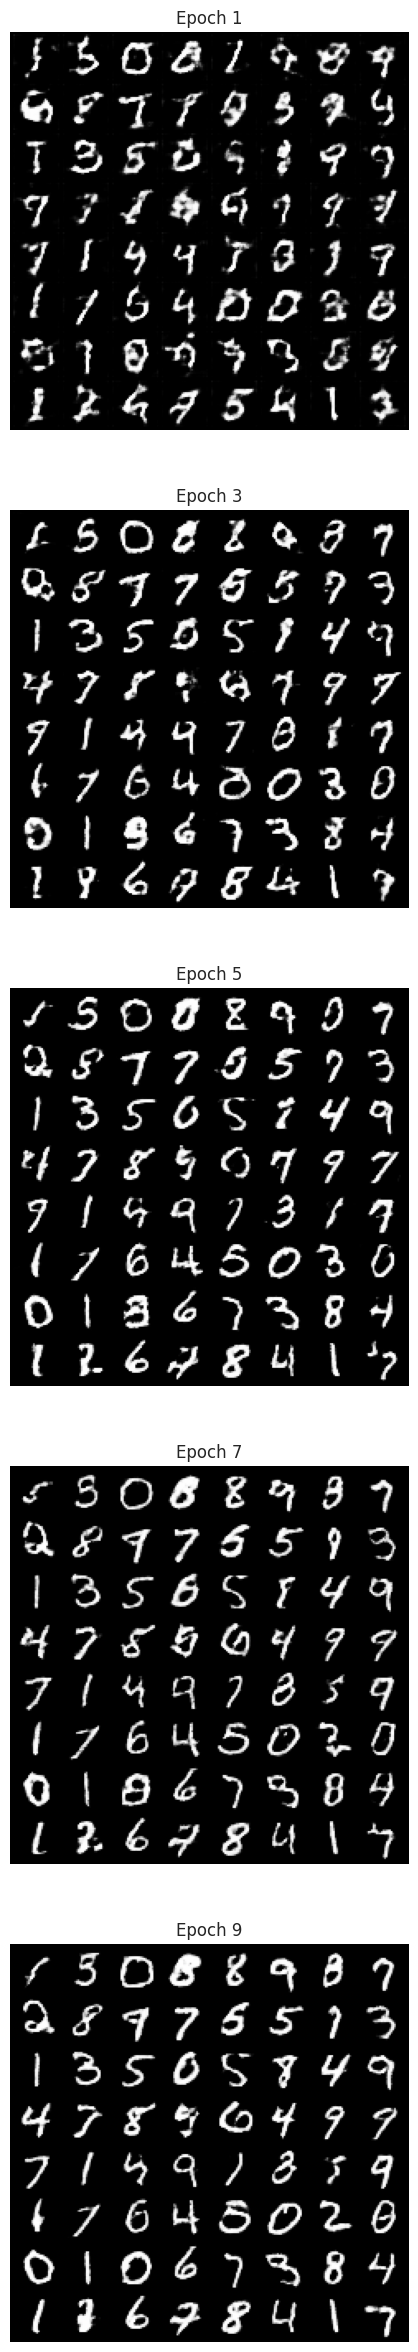

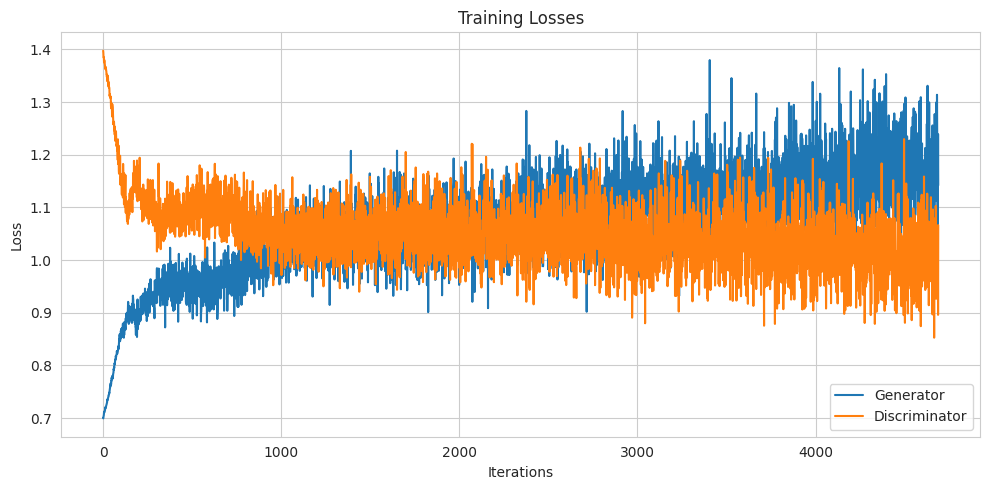

Комбинация 4: lr=0.0002, beta1=0.6, latent_dim=100
[Epoch 1/10] Loss_D: 1.1068 Loss_G: 0.9883
[Epoch 3/10] Loss_D: 1.0775 Loss_G: 1.0715
[Epoch 5/10] Loss_D: 1.0176 Loss_G: 1.0760
[Epoch 7/10] Loss_D: 1.0082 Loss_G: 1.0933
[Epoch 9/10] Loss_D: 1.0430 Loss_G: 1.1393


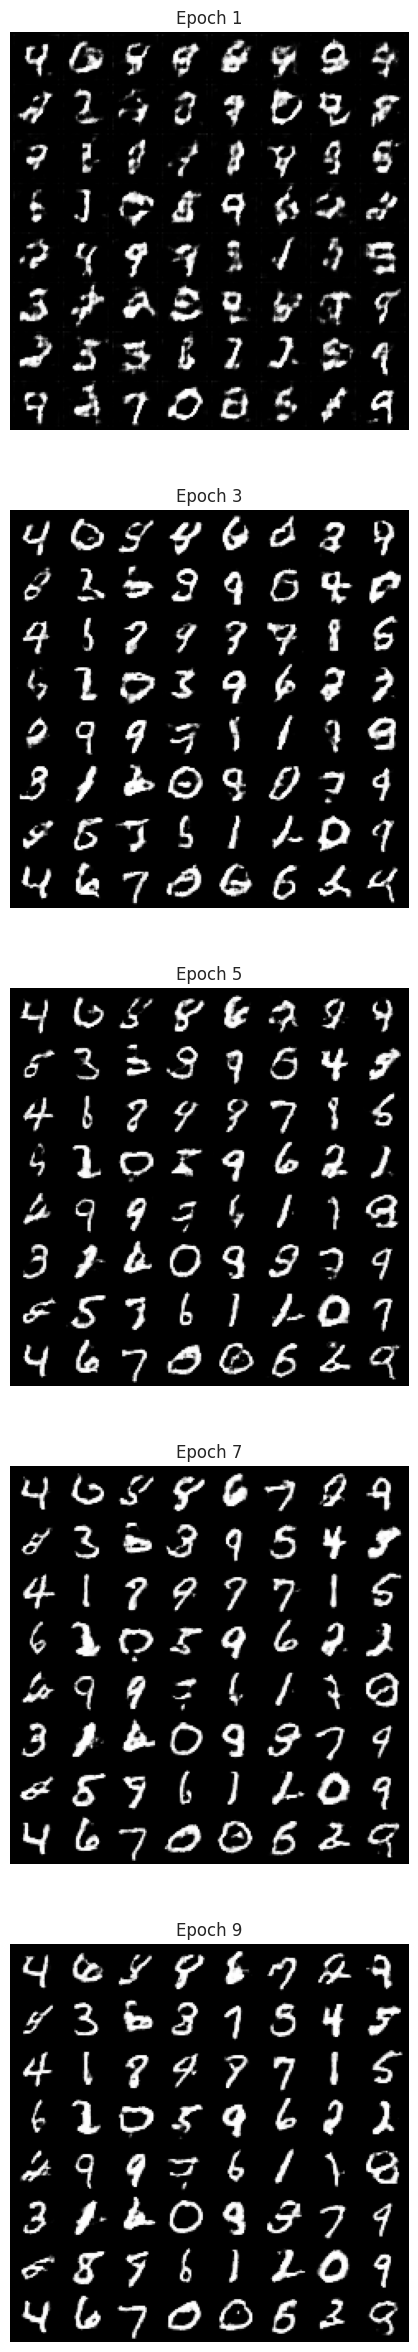

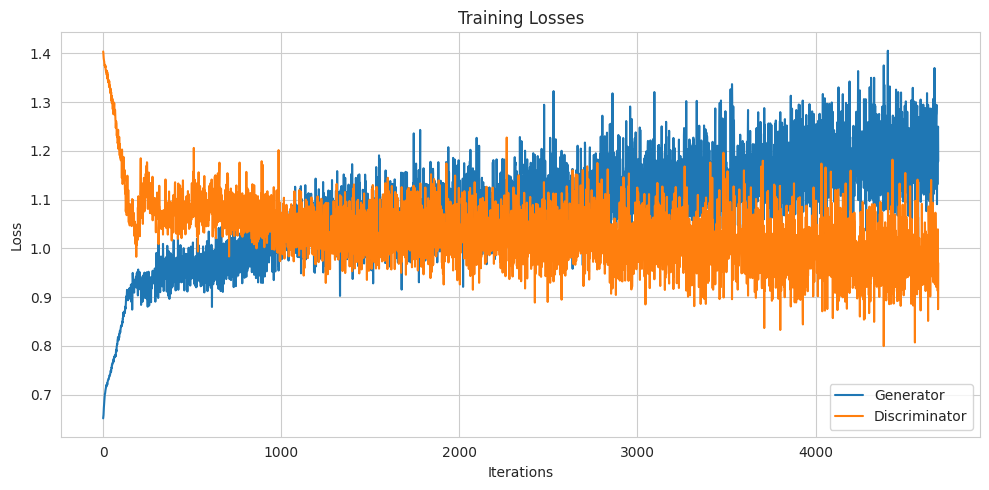

Комбинация 5: lr=0.001, beta1=0.5, latent_dim=80
[Epoch 1/10] Loss_D: 1.1696 Loss_G: 0.9781
[Epoch 3/10] Loss_D: 1.2033 Loss_G: 1.0294
[Epoch 5/10] Loss_D: 1.1457 Loss_G: 1.2252
[Epoch 7/10] Loss_D: 1.1882 Loss_G: 1.2622
[Epoch 9/10] Loss_D: 0.9558 Loss_G: 1.0516


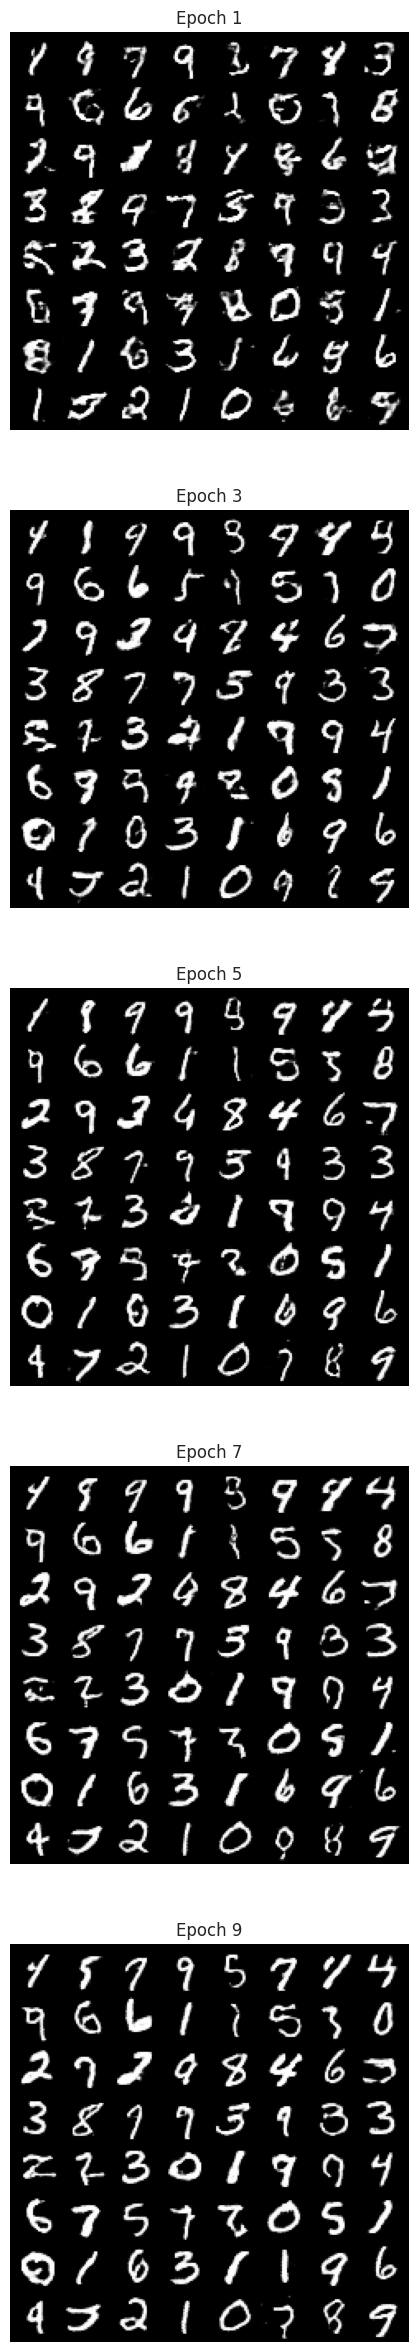

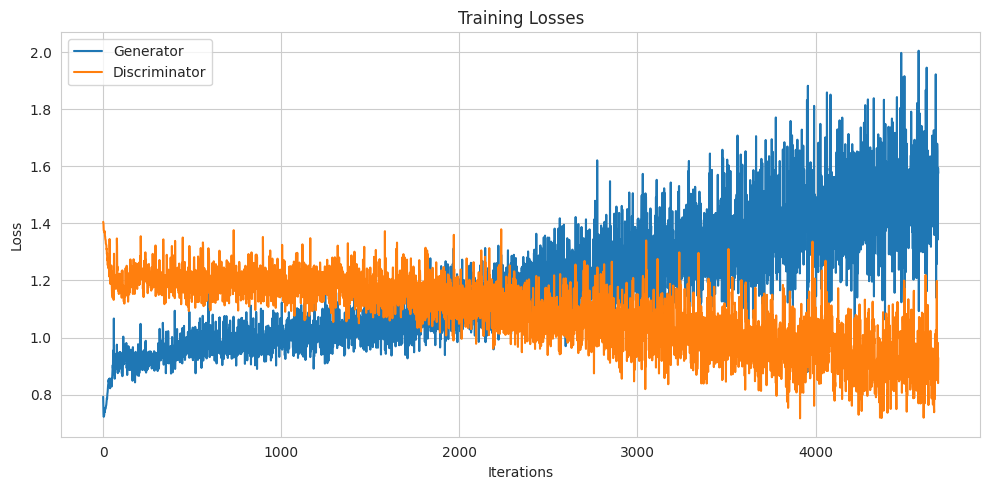

Комбинация 6: lr=0.001, beta1=0.5, latent_dim=100
[Epoch 1/10] Loss_D: 1.2018 Loss_G: 0.9451
[Epoch 3/10] Loss_D: 1.1966 Loss_G: 1.0699
[Epoch 5/10] Loss_D: 1.2151 Loss_G: 1.1065
[Epoch 7/10] Loss_D: 1.1176 Loss_G: 1.0772
[Epoch 9/10] Loss_D: 1.0512 Loss_G: 1.3983


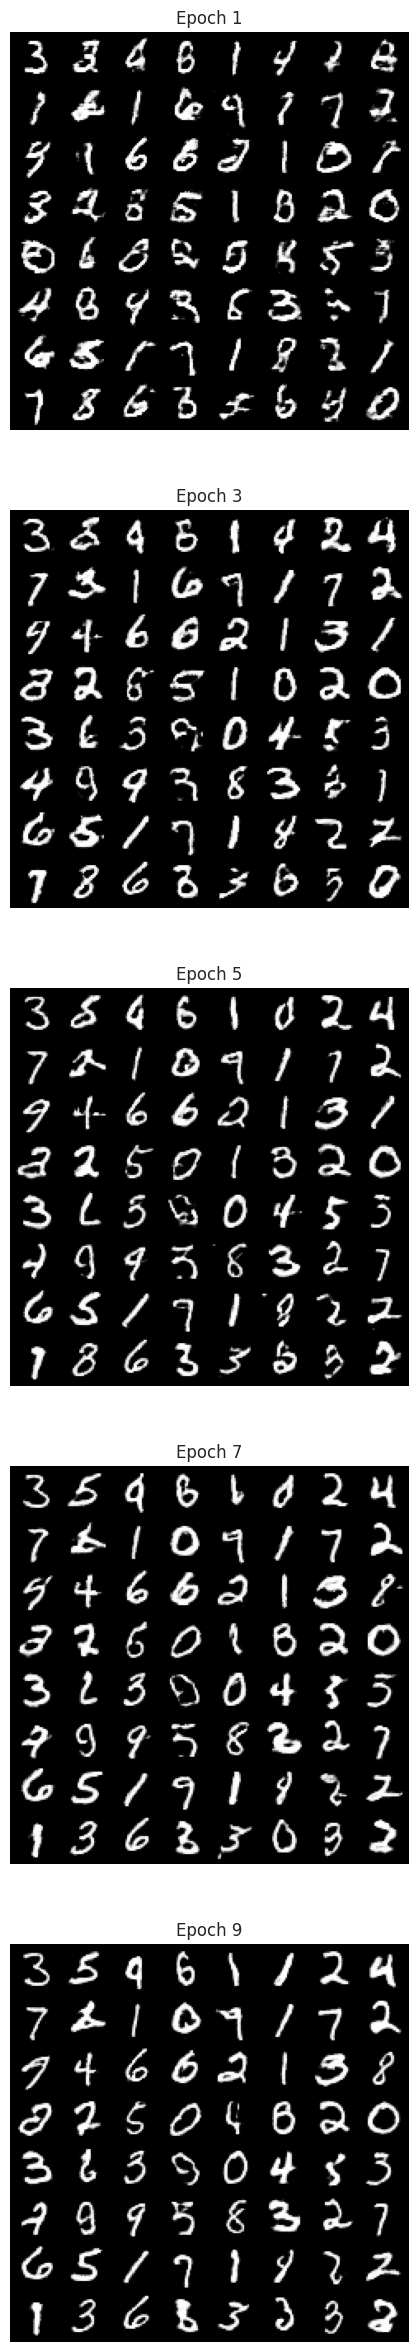

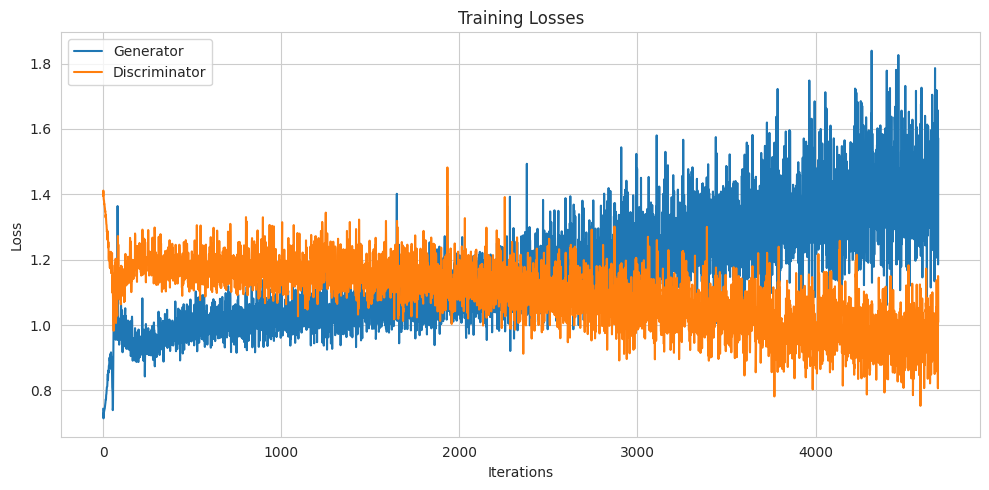

Комбинация 7: lr=0.001, beta1=0.6, latent_dim=80
[Epoch 1/10] Loss_D: 0.0591 Loss_G: 3.8747
[Epoch 3/10] Loss_D: 0.0033 Loss_G: 6.0118
[Epoch 5/10] Loss_D: 0.9335 Loss_G: 1.4995
[Epoch 7/10] Loss_D: 1.1286 Loss_G: 1.3488
[Epoch 9/10] Loss_D: 1.0816 Loss_G: 1.3434


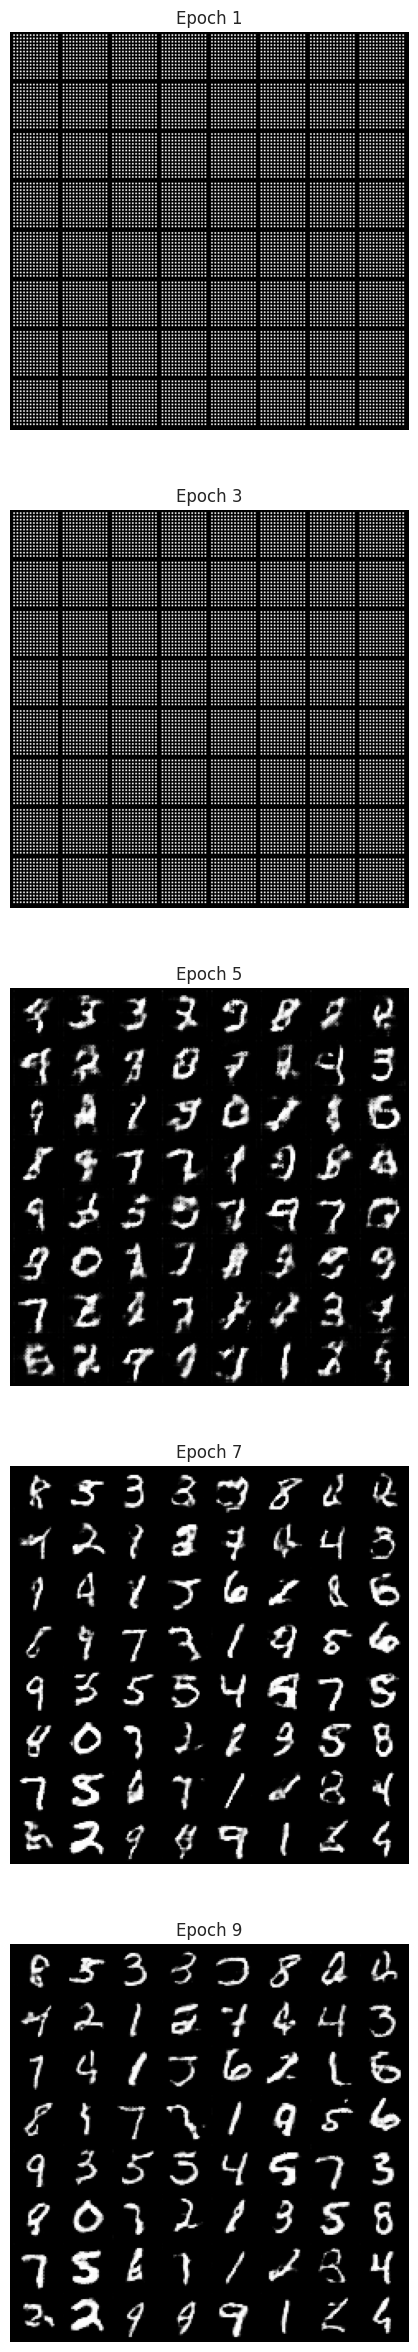

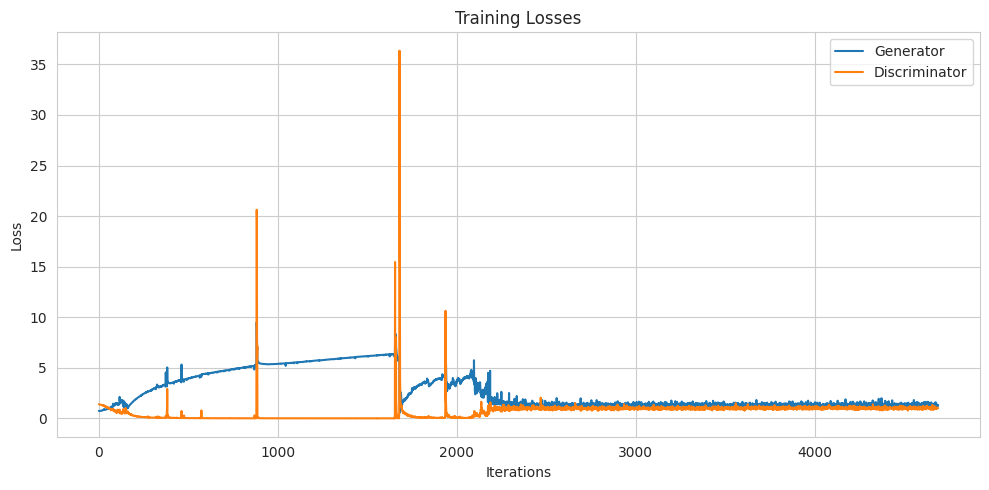

Комбинация 8: lr=0.001, beta1=0.6, latent_dim=100
[Epoch 1/10] Loss_D: 1.0663 Loss_G: 1.0462
[Epoch 3/10] Loss_D: 1.1198 Loss_G: 1.0890
[Epoch 5/10] Loss_D: 1.1060 Loss_G: 1.2683
[Epoch 7/10] Loss_D: 1.0887 Loss_G: 1.2258
[Epoch 9/10] Loss_D: 1.0294 Loss_G: 1.4310


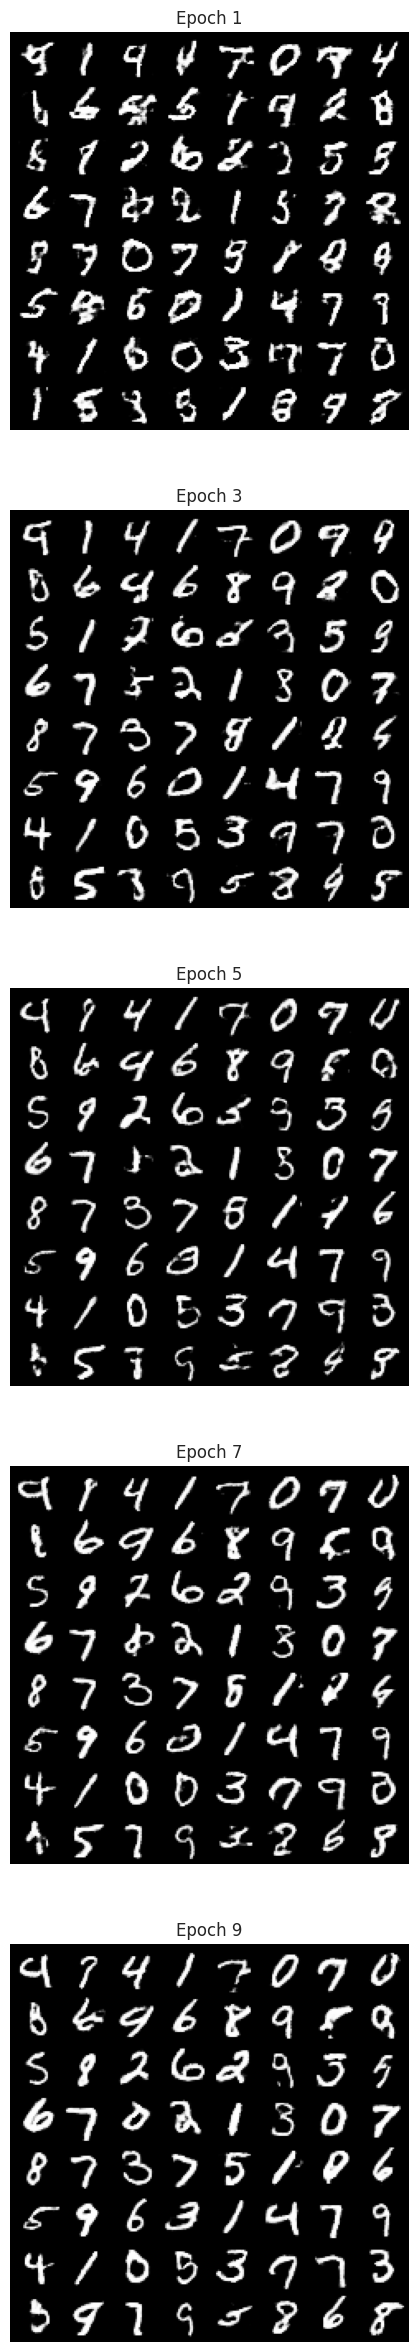

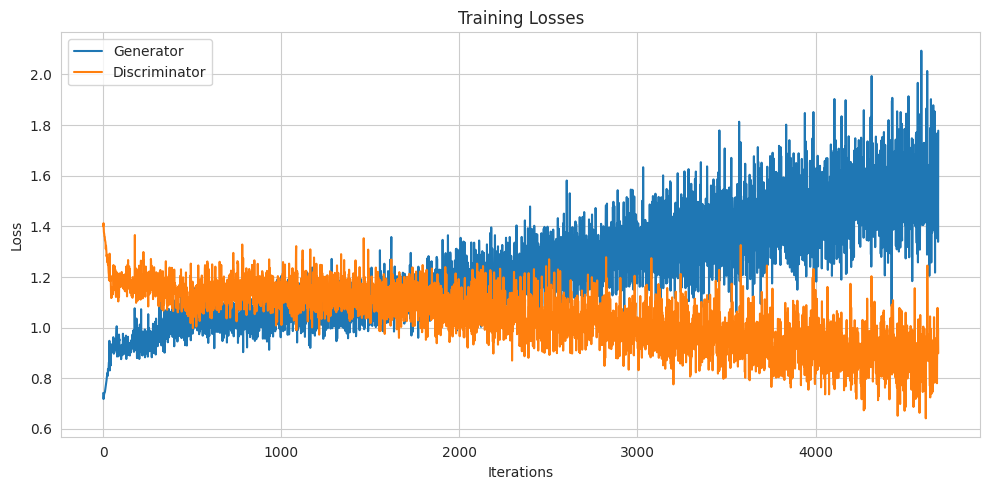

In [114]:
import itertools

# Списки значений
lr_values = [0.0002, 0.001]
beta1_values = [0.5, 0.6]
latent_dim_values = [80, 100]

# Получаем все комбинации
combinations = list(itertools.product(lr_values, beta1_values, latent_dim_values))

# Печатаем результат
for idx, (lr, beta1, latent_dim) in enumerate(combinations):
    print(f"Комбинация {idx+1}: lr={lr}, beta1={beta1}, latent_dim={latent_dim}")
    train(lr, latent_dim, beta1)

####  Simple copmare VIT and CNN  

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [154]:
# Гиперпараметры
batch_size = 128
num_workers = 4
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [155]:
class MLPBlock(nn.Module):
    def __init__(self, embed_dim, mlp_hidden_dim):
        super(MLPBlock, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, embed_dim)
        )

    def forward(self, x):
        return self.mlp(x)

In [156]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (img_size // patch_size) ** 2
        
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.projection(x)  # [batch, embed_dim, grid, grid]
        x = x.flatten(2).transpose(1, 2)  # [batch, grid*grid, embed_dim]
        
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        x += self.pos_embedding
        return x

In [157]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(AttentionBlock, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B, num_heads, N, head_dim]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

In [158]:
import torch
import torchvision.models as models

resnet = models.resnet18(pretrained=False)

#(10 классов вместо 1000 ImageNet)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

In [159]:
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, embed_dim=192, num_heads=3, depth=3, mlp_hidden_dim=384):
        super(ViT, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(embed_dim),
                AttentionBlock(embed_dim, num_heads),
                nn.LayerNorm(embed_dim),
                MLPBlock(embed_dim, mlp_hidden_dim)
            )
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x[:, 0]) # Берём только cls токен
        x = self.head(x)
        return x

In [160]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [161]:
def test(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

In [ ]:
# Модели
vit_model = ViT(img_size=32, patch_size=2, in_channels=3, num_classes=10, embed_dim=192, num_heads=3, depth=3, mlp_hidden_dim=384).to(device)
cnn_model = resnet

optimizer_vit = optim.Adam(vit_model.parameters(), lr=0.001)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

vit_losses = []
vit_test_accuracies = []
cnn_losses = []
cnn_test_accuracies = []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    vit_loss, _ = train(vit_model, train_loader, criterion, optimizer_vit, device)
    vit_losses.append(vit_loss)
    
    cnn_loss, _ = train(cnn_model, train_loader, criterion, optimizer_cnn, device)
    cnn_losses.append(cnn_loss)
    
    vit_test_acc = test(vit_model, test_loader, device)
    cnn_test_acc = test(cnn_model, test_loader, device)
    vit_test_accuracies.append(vit_test_acc)
    cnn_test_accuracies.append(cnn_test_acc)
    print(f'ViT: Train Loss={vit_loss:.4f},  Test Acc={vit_test_acc:.2f}%')
    print(f'CNN: Train Loss={cnn_loss:.4f},  Test Acc={cnn_test_acc:.2f}%')

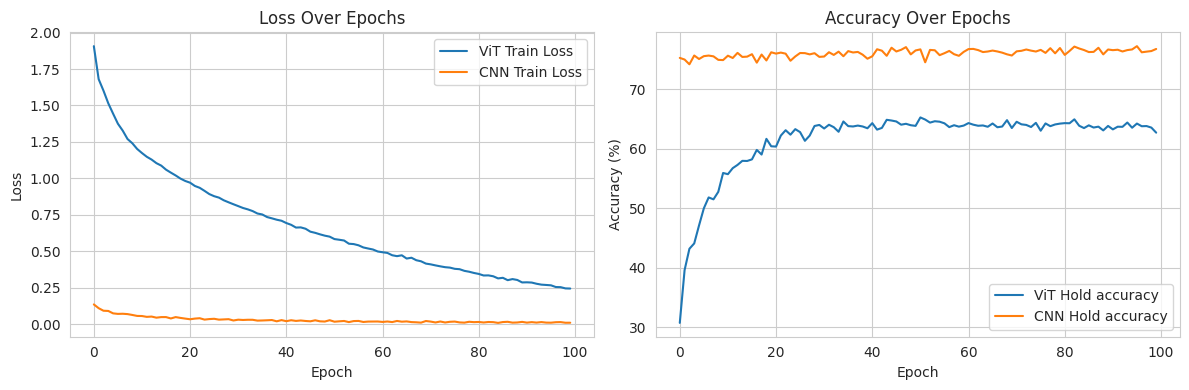

In [164]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vit_losses, label='ViT Train Loss')
plt.plot(cnn_losses, label='CNN Train Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# чекнем,как скоро переобучается CNN и как быстро ползёт ViT
plt.subplot(1, 2, 2)
plt.plot(vit_test_accuracies, label='ViT Hold accuracy')
plt.plot(cnn_test_accuracies, label='CNN Hold accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()